In [1]:
from pathlib import Path
import pickle
import numpy as np
import re

## Load training set documents

In [2]:
results_dir = Path("../results")
pickle_file = "stanza_proc_train.pkl"

in_path = results_dir / pickle_file

with open(in_path, 'rb') as infile:
    train_set = pickle.load(infile)

/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
for key, value in train_set[0].items():
    print(key, type(value), sep='\t')

id	<class 'str'>
raw_text	<class 'str'>
hs	<class 'int'>
stereotype	<class 'int'>
proc_text	<class 'stanza.models.common.doc.Document'>


## Analyze Style

In [4]:
def is_nominal(sentence):
    """A sentence is nominal when it lacks a finite verb form
    in its main clause."""
    root = sentence.root
    if root.upos == "VERB":
        if not root.feats:
            return False
        elif 'VerbForm=Fin' not in root.feats:
            return 'aux' not in sentence.root_deps
        else:
            return False
    else:
        return 'cop' not in sentence.root_deps

In [5]:
from stanza.models.common.doc import Sentence, Document
import stanza

# I need the same pipeline as in dependency parcing in order to extract some information from the processors
nlp = stanza.Pipeline(lang='it', processors='tokenize,mwt,pos,lemma,depparse')


Sentence.add_property('n_tokens', default=0, getter=lambda self: len(self.tokens))
Sentence.add_property('n_words', default=0, getter=lambda self: len(self.words))
Sentence.add_property('lemmas', default=set(), getter=lambda self: set([word.lemma for word in self.words]))
Sentence.add_property('forms', default=set(), getter=lambda self: set([word.text.lower() for word in self.words]))
Document.add_property('n_sentences', default=0, getter=lambda self: len(self.sentences))
Document.add_property('avg_sent_length', default=0, getter=lambda self: np.mean([sent.n_tokens for sent in self.sentences]))
Document.add_property('avg_word_length', default=0, getter=lambda self: np.mean([len(token.text)
                                                                                 for sent in self.sentences for token in sent.tokens
                                                                               if token.words[0].upos != 'PUNCT']))
Document.add_property('lemmas', default=set(), getter=lambda self: {lemma
                                                                for sent in self.sentences
                                                                for lemma in sent.lemmas})
Document.add_property('forms', default=set(), getter=lambda self: {form
                                                                   for sent in self.sentences
                                                                   for form in sent.forms})
Document.add_property('ttr_lemma', default=0, getter=lambda self: len(self.lemmas) / self.num_words)
Document.add_property('ttr_form', default=0, getter=lambda self: len(self.forms) / self.num_words)

Sentence.add_property('root', default=dict(), getter=lambda self: [word
                                                                   for word in self.words
                                                                   if word.deprel == 'root'][0])
Sentence.add_property('root_deps', default=[], getter=lambda self: [deprel
                                                                    for head, deprel, _ in self.dependencies
                                                                    if head == self.root])
Sentence.add_property('is_nominal', default=False, getter=lambda self: is_nominal(self))
Document.add_property('n_nominal_sents', default=0, getter=lambda self: sum([sent.is_nominal
                                                                             for sent in self.sentences]))
Document.add_property('n_uppercase_words', default=0, getter=lambda self: sum([token.text.isupper()
                                                                            for token
                                                                            in self.iter_tokens()
                                                                            if len(token.text) > 1]))

2024-12-29 10:45:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-12-29 10:45:17 INFO: Downloaded file to /home/fab/stanza_resources/resources.json
2024-12-29 10:45:18 INFO: Loading these models for language: it (Italian):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2024-12-29 10:45:19 INFO: Using device: cpu
2024-12-29 10:45:19 INFO: Loading: tokenize
/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pick

In [6]:
HASHTAG_RE = re.compile(r'#([\w]+)')
UPOS_CONTENT = ['NOUN', 'PROPN', 'ADJ', 'ADV', 'VERB']
UPOS_ALL = nlp.processors['pos'].get_known_upos()
DEPREL_ALL = nlp.processors['depparse'].get_known_relations()

In [7]:
class StyleAnalyzer:
    def __init__(self, document: dict) -> None:
        self.id = document.get('id')
        self.raw_text = document.get('raw_text')
        self.hs = document.get('hs')
        self.stereotype = document.get('stereotype')
        self.proc_text = document.get('proc_text')
        self.style_feats = dict()

        self.analyze()

    def get_num_tokens(self):
        return self.proc_text.num_tokens

    def get_num_words(self):
        return self.proc_text.num_words

    def get_num_sentences(self):
        return self.proc_text.n_sentences

    def get_avg_sent_length(self):
        return self.proc_text.avg_sent_length

    def get_avg_word_length(self):
        return self.proc_text.avg_word_length

    def get_num_uppercase_words(self):
        """Number of words at least 2 characters long that are all in uppercase"""
        return self.proc_text.n_uppercase_words

    def get_num_mentions(self):
        return self.raw_text.count('@user')

    def get_num_urls(self):
        return self.raw_text.count('URL')

    def get_num_hashtags(self):
        return len(HASHTAG_RE.findall(self.raw_text))

    def get_ttr_lemma(self):
        """
        Type Token ratio computed with respect to lemmas.
        Ranges between 1 (high lexical variety) and 0 (low lexical variety).
        """
        return self.proc_text.ttr_lemma

    def get_ttr_form(self):
        """
        Type Token ratio computed with respect to forms
        Ranges between 1 (high lexical variety) and 0 (low lexical variety).
        """
        return self.proc_text.ttr_form

    def get_num_nominal_sents(self):
        """
        Number of nominal sentences.
        A nominal sentence is defined by the absence of a finite verb
        heading it's main clause.
        """
        return self.proc_text.n_nominal_sents

    def get_num_verbal_roots(self):
        """Number of sentences headed by a verb"""
        return sum([sentence.root.upos == 'VERB'
                    for sentence in self.proc_text.sentences])

    def get_upos_dist(self):
        """Distribution of grammatical categories (upos)"""
        num_words = self.get_num_words()

        dist = {f"upos_dist_{pos_tag}": 0 for pos_tag in UPOS_ALL}
        for sentence in self.proc_text.sentences:
            for word in sentence.words:
                dist[f"upos_dist_{word.upos}"] += 1

        return {feat_name: n / num_words
                for feat_name, n in dist.items()}

    def get_deprel_dist(self):
        """Distribution of dependency relationships (deprel)"""
        num_words = self.get_num_words()

        dist = {f"deprel_dist_{deprel}": 0 for deprel in DEPREL_ALL}
        for sentence in self.proc_text.sentences:
            for word in sentence.words:
                dist[f"deprel_dist_{word.deprel}"] += 1

        return {feat_name: n / num_words
                for feat_name, n in dist.items()}


    def get_num_content_words(self):
        """Number of content words: NOUN PROPN ADV ADJ VERB"""
        return len([word
                    for sent in self.proc_text.sentences
                    for word in sent.words
                    if word.upos in UPOS_CONTENT])

    def get_verb_object_order(self):
        """Distribution of objects preceding and following the verb"""
        objs = [(word.id, word.head)
                for sent in self.proc_text.sentences
                for word in sent.words
                if word.deprel == 'obj']
        num_objs = len(objs)
        try:
            obj_pre = sum([obj < head for obj, head in objs]) / num_objs
            obj_post = 1 - obj_pre
        except ZeroDivisionError:
            # Handle no objs in document
            obj_pre = 0
            obj_post = 0
        return {
            'obj_pre': obj_pre,
            'obj_post': obj_post
        }

    def get_verb_subject_order(self):
        """Distribution of subjects preceding and following the verb"""
        subjs = [(word.id, word.head)
                 for sent in self.proc_text.sentences
                 for word in sent.words
                 if word.deprel == 'subj']
        num_subjs = len(subjs)

        try:
            subj_pre = sum(subj < head for subj, head in subjs) / num_subjs
            subj_post = 1 - subj_pre
        except ZeroDivisionError:
            # Handle no subjs in document
            subj_pre = 0
            subj_post = 0
        return {
            'subj_pre': subj_pre,
            'subj_post': subj_post
        }


    def analyze(self):
        # Raw text properties
        num_tokens = self.get_num_tokens()
        num_sentences = self.get_num_sentences()
        num_words = self.get_num_words()
        self.style_feats['num_tokens'] = num_tokens
        self.style_feats['num_sentences'] = num_sentences
        # Sentence and word length are proxies of syntactic complexity
        self.style_feats['avg_sent_length'] = self.get_avg_sent_length()
        self.style_feats['avg_word_length'] = self.get_avg_word_length()

        # Social media language properties
        self.style_feats['uppercase_words_dist'] = self.get_num_uppercase_words() / num_tokens
        self.style_feats['num_mentions'] = self.get_num_mentions()
        self.style_feats['num_hashtags'] = self.get_num_hashtags()
        self.style_feats['num_urls'] = self.get_num_urls()

        # Lexical variety
        self.style_feats['ttr_lemma'] = self.get_ttr_lemma()
        self.style_feats['ttr_form'] = self.get_ttr_form()

        # Morphosyntactic information
        self.style_feats.update(self.get_upos_dist())
        self.style_feats['lexical_density'] = self.get_num_content_words() / num_words

        # Syntactic features
        self.style_feats['nominal_sents_dist'] = self.get_num_nominal_sents() / num_sentences
        self.style_feats['verbal_root_dist'] = self.get_num_verbal_roots() / num_sentences
        # Syntactic relations
        self.style_feats.update(self.get_deprel_dist())
        # Order of core arguments
        self.style_feats.update(self.get_verb_object_order())
        self.style_feats.update(self.get_verb_subject_order())

    def to_dict(self):
        doc =  dict(
            id=self.id,
            hs=self.hs,
            stereotype=self.stereotype,
            raw_text=self.raw_text,
        )
        doc.update(self.style_feats)
        return doc


In [8]:
doc = StyleAnalyzer(train_set[4])
print(doc.raw_text)
doc.to_dict()

Il divertimento del giorno? Trovare i patrioti italiani che inneggiano contro i rom facendo la spesa alla #Lidl (multinazionale tedesca). 


{'id': '949',
 'hs': 0,
 'stereotype': 0,
 'raw_text': 'Il divertimento del giorno? Trovare i patrioti italiani che inneggiano contro i rom facendo la spesa alla #Lidl (multinazionale tedesca). ',
 'num_tokens': 24,
 'num_sentences': 2,
 'avg_sent_length': 12.0,
 'avg_word_length': 5.65,
 'uppercase_words_dist': 0.0,
 'num_mentions': 0,
 'num_hashtags': 1,
 'num_urls': 0,
 'ttr_lemma': 0.8076923076923077,
 'ttr_form': 0.8846153846153846,
 'upos_dist_NOUN': 0.23076923076923078,
 'upos_dist_DET': 0.23076923076923078,
 'upos_dist_ADP': 0.11538461538461539,
 'upos_dist_PUNCT': 0.15384615384615385,
 'upos_dist_VERB': 0.11538461538461539,
 'upos_dist_PRON': 0.038461538461538464,
 'upos_dist_ADJ': 0.07692307692307693,
 'upos_dist_PROPN': 0.038461538461538464,
 'upos_dist_ADV': 0.0,
 'upos_dist_AUX': 0.0,
 'upos_dist_CCONJ': 0.0,
 'upos_dist_SYM': 0.0,
 'upos_dist_NUM': 0.0,
 'upos_dist_SCONJ': 0.0,
 'upos_dist_X': 0.0,
 'upos_dist_INTJ': 0.0,
 'upos_dist_PART': 0.0,
 'lexical_density': 0.4615

In [9]:
analyzed_docs = [StyleAnalyzer(doc) for doc in train_set]

In [10]:
import pandas as pd

In [11]:
train_df = pd.DataFrame.from_records([doc.to_dict() for doc in analyzed_docs], index='id').fillna(0)

In [12]:
train_df.head()

,hs,stereotype,raw_text,num_tokens,num_sentences,avg_sent_length,avg_word_length,uppercase_words_dist,num_mentions,num_hashtags,...,deprel_dist_parataxis:obj,deprel_dist_parataxis:discourse,deprel_dist_goeswith,deprel_dist_csubj:pass,deprel_dist_nsubj:outer,deprel_dist_reparandum,obj_pre,obj_post,subj_pre,subj_post
id,,,,,,,,,,,,,,,,,,,,,
2066,0,0,"È terrorismo anche questo, per mettere in uno ...",20,1,20.0,5.166667,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2045,0,0,@user @user infatti finché ci hanno guadagnato...,15,1,15.0,4.733333,0.0,2,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
61,0,0,"Corriere: Tangenti, Mafia Capitale dimenticata...",13,1,13.0,6.181818,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1259,0,0,"@user ad uno ad uno, perché quando i migranti ...",21,1,21.0,4.789474,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
949,0,0,Il divertimento del giorno? Trovare i patrioti...,24,2,12.0,5.650000,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0


In [13]:
print(train_df.shape)
train_df.columns

(6837, 94)


Index(['hs', 'stereotype', 'raw_text', 'num_tokens', 'num_sentences',
       'avg_sent_length', 'avg_word_length', 'uppercase_words_dist',
       'num_mentions', 'num_hashtags', 'num_urls', 'ttr_lemma', 'ttr_form',
       'upos_dist_NOUN', 'upos_dist_DET', 'upos_dist_ADP', 'upos_dist_PUNCT',
       'upos_dist_VERB', 'upos_dist_PRON', 'upos_dist_ADJ', 'upos_dist_PROPN',
       'upos_dist_ADV', 'upos_dist_AUX', 'upos_dist_CCONJ', 'upos_dist_SYM',
       'upos_dist_NUM', 'upos_dist_SCONJ', 'upos_dist_X', 'upos_dist_INTJ',
       'upos_dist_PART', 'lexical_density', 'nominal_sents_dist',
       'verbal_root_dist', 'deprel_dist_det', 'deprel_dist_punct',
       'deprel_dist_case', 'deprel_dist_nmod', 'deprel_dist_root',
       'deprel_dist_obl', 'deprel_dist_amod', 'deprel_dist_nsubj',
       'deprel_dist_expl', 'deprel_dist_advmod', 'deprel_dist_conj',
       'deprel_dist_obj', 'deprel_dist_cc', 'deprel_dist_mark',
       'deprel_dist_aux', 'deprel_dist_parataxis', 'deprel_dist_flat:name',

## Classifier

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [15]:
train_X = train_df.drop(['hs', 'stereotype', 'raw_text'], axis=1)
train_y = train_df['hs']

In [16]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LinearSVC(dual=False, max_iter=10000))
], verbose=True)

pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf', LinearSVC(dual=False, max_iter=10000))],
         verbose=True)

In [17]:
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [18]:

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'f1_positive': make_scorer(f1_score, pos_label=1, zero_division=0)
}

In [19]:
parameter_grid = {
    "clf__C": (1, 10, 100, 1000),
    "clf__penalty": ('l1', 'l2')
}

grid_search = GridSearchCV(
    estimator=pipeline,
    scoring=make_scorer(f1_score, average="macro", zero_division=0),
    param_grid=parameter_grid,
    refit=True,
    cv=splitter,
    verbose=2,
    return_train_score=True
)

In [20]:
%%time
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.0s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   2.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.2s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   1.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   1.2s
[Pipeline] ............ (step 1 of 2) Processing

/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.2s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   3.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.8s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   1.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[CV] END .........................clf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('clf',
                                        LinearSVC(dual=False, max_iter=10000))],
                                verbose=True),
             param_grid={'clf__C': (1, 10, 100, 1000),
                         'clf__penalty': ('l1', 'l2')},
             return_train_score=True,
             scoring=make_scorer(f1_score, response_method='predict', average=macro, zero_division=0),
             verbose=2)

In [21]:
best_estimator = grid_search.best_estimator_
grid_search.best_params_

{'clf__C': 10, 'clf__penalty': 'l1'}

In [22]:
scores = cross_validate(best_estimator, train_X, train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1", np.mean(scores['test_f1_macro']).round(3))
print("Standard deviation macro-f1", np.std(scores['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.1s
Mean macro-f1 0.666
Standard deviation macro-f1 0.01


We compare the scores obtained by the linear support vector machine with the performance obtained by a dummy classifier that always predicts the most frequent class (i.e. not hate speech).

In [23]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
baseline_scores = cross_validate(dummy_clf, train_X, train_y, scoring=scoring, cv=splitter, n_jobs=1)
print(baseline_scores.keys())

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_f1_positive'])


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
scores_df = pd.DataFrame(scores)
scores_df['model'] = 'actual model'
scores_df['iteration'] = list(range(1, 6))
baseline_scores_df = pd.DataFrame(baseline_scores)
baseline_scores_df['model'] = 'dummy classifier'
baseline_scores_df['iteration'] = list(range(1, 6))

scores_df = pd.concat([scores_df, baseline_scores_df]).drop(['fit_time', 'score_time'], axis=1)
scores_df_long = pd.melt(scores_df, id_vars=['model', 'iteration'], var_name='metric')

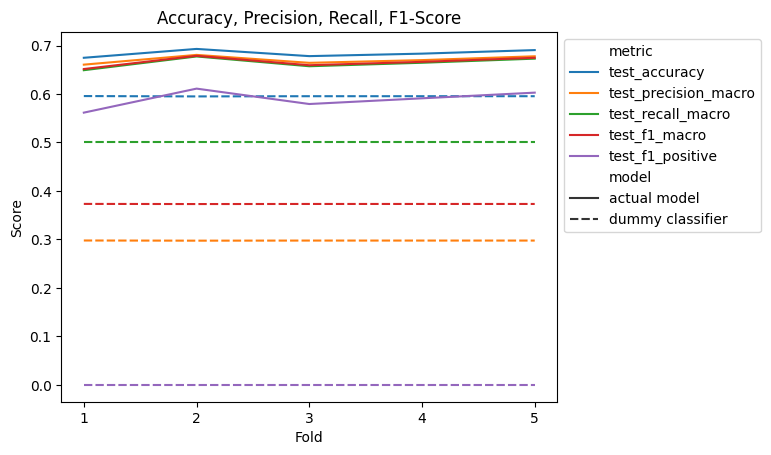

In [26]:
sns.lineplot(scores_df_long, x='iteration', y='value', hue='metric', style='model')
plt.xticks(list(range(1, 6)))
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Accuracy, Precision, Recall, F1-Score")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.6s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.7s


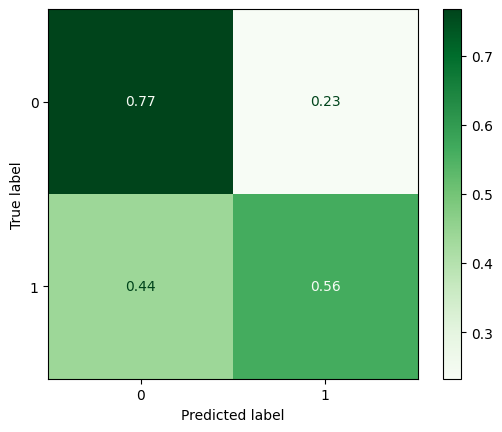

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = cross_val_predict(best_estimator, train_X, train_y, cv=splitter)
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=train_y, cmap="Greens", normalize='true')
plt.show()

## Feature importance

In [28]:
best_estimator.fit(train_X, train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.4s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 LinearSVC(C=10, dual=False, max_iter=10000, penalty='l1'))],
         verbose=True)

In [29]:
coefs = best_estimator['clf'].coef_[0]
feat_names = best_estimator[:-1].get_feature_names_out()

Most important features for positive class (hs)

In [30]:
feat_importance = pd.DataFrame(coefs, columns=("coef",), index=feat_names)
feat_importance.sort_values('coef', ascending=False).head()

,coef
num_sentences,1.529455
upos_dist_AUX,1.500569
avg_word_length,1.014725
uppercase_words_dist,0.968752
deprel_dist_det:predet,0.841653


Most important features for negative class (not hs)

In [31]:
feat_importance.sort_values('coef', ascending=True).head()

,coef
deprel_dist_aux,-1.493638
num_urls,-1.408938
deprel_dist_vocative:mention,-1.199717
deprel_dist_cop,-1.167144
deprel_dist_punct,-0.959199


### Save documents with stylistic features for further analysis

In [32]:
results_dir = Path("../results")
outpath = results_dir / 'style_feats_train.csv'

train_df.to_csv(outpath)

In [33]:
results_report = [f"{np.mean(scores['test_' + metric]).round(3)} ({np.std(scores['test_' + metric]).round(3)})"
                  for metric in scoring]

In [34]:
with open(results_dir / 'tables' / 'performance_validation.csv', 'a') as outfile:
    outfile.writelines("style_svc,Linear SVC with 91 stylistic features C=10," + ','.join(results_report) + '\n')

## Stylistic analysis of scraped headlines

In [35]:
pickle_file = 'stanza_proc_train_headlines.pkl'

with open(results_dir / pickle_file, 'rb') as infile:
    headlines = pickle.load(infile)

In [36]:
analyzed_docs = [StyleAnalyzer(doc) for doc in headlines]
headlines_df = pd.DataFrame.from_records([doc.to_dict() for doc in analyzed_docs], index='id').fillna(0)
headlines_df['hs'] = np.nan
headlines_df['stereotype'] = np.nan

/tmp/ipykernel_15319/2428648722.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  headlines_df = pd.DataFrame.from_records([doc.to_dict() for doc in analyzed_docs], index='id').fillna(0)


In [37]:
headlines_df['type'] = 'headline'
train_df['type'] = 'tweet'

df = pd.concat([train_df, headlines_df])

### Classifier

We use a simple linear support vector machine in order to appraise which stylistic features are more useful for establishing if a document is a tweet or a newspaper headline.

In [38]:
train_X = df.drop(['type', 'raw_text', 'hs', 'stereotype'], axis=1)
train_y = df['type']
scoring.pop('f1_positive')

scores = cross_validate(best_estimator, train_X, train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1", np.mean(scores['test_f1_macro']).round(3))
print("Standard deviation macro-f1", np.std(scores['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.4s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.1s
Mean macro-f1 0.949
Standard deviation macro-f1 0.004


/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.4s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.4s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   5.2s


/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


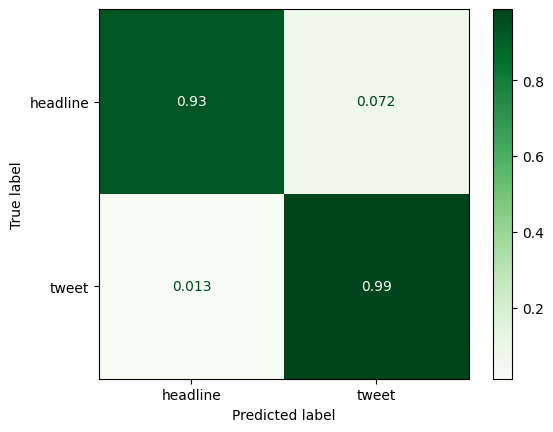

In [39]:

y_pred = cross_val_predict(best_estimator, train_X, train_y, cv=splitter)
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=train_y, cmap="Greens", normalize='true')
plt.show()

As we can see, the classificator is able to distinguish between tweets and headlines with great ease.

In [40]:
best_estimator.fit(train_X, train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.0s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 LinearSVC(C=10, dual=False, max_iter=10000, penalty='l1'))],
         verbose=True)

In [41]:
coefs = best_estimator['clf'].coef_[0]
feat_names = best_estimator[:-1].get_feature_names_out()
feat_importance = pd.DataFrame(coefs, columns=("coef",), index=feat_names)
feat_importance.sort_values('coef', ascending=False).head(15)

,coef
num_mentions,132.533727
num_hashtags,39.977077
num_urls,19.585665
num_tokens,11.046477
uppercase_words_dist,5.215871
deprel_dist_vocative,3.586694
upos_dist_SYM,3.386084
upos_dist_PRON,2.728811
upos_dist_AUX,2.647019
deprel_dist_dislocated,2.294404


In [42]:
feat_importance.sort_values('coef', ascending=True).head(6)

,coef
deprel_dist_expl:impers,-6.258162
deprel_dist_cop,-2.828820
deprel_dist_punct,-2.718738
deprel_dist_expl,-1.975327
deprel_dist_aux,-1.869635
ttr_form,-1.847602


As expected, tweets differ from headlines mainly for social media language properties like the number of mentions, hashtags and urls and the use of uppercase. In addition to that, tweets tend to be longer and to have longer sentences than headlines and exhibit in general a non standard syntax, as manifested by the frequency of discourse elements, dislocations, vocatives, and lists.

On the other hand, headlines seem to use more punctuation and more proper nouns and exhibit higher lexical variety (but since the TTR measure is highly sensitive to the text length this is probably an spurious result).

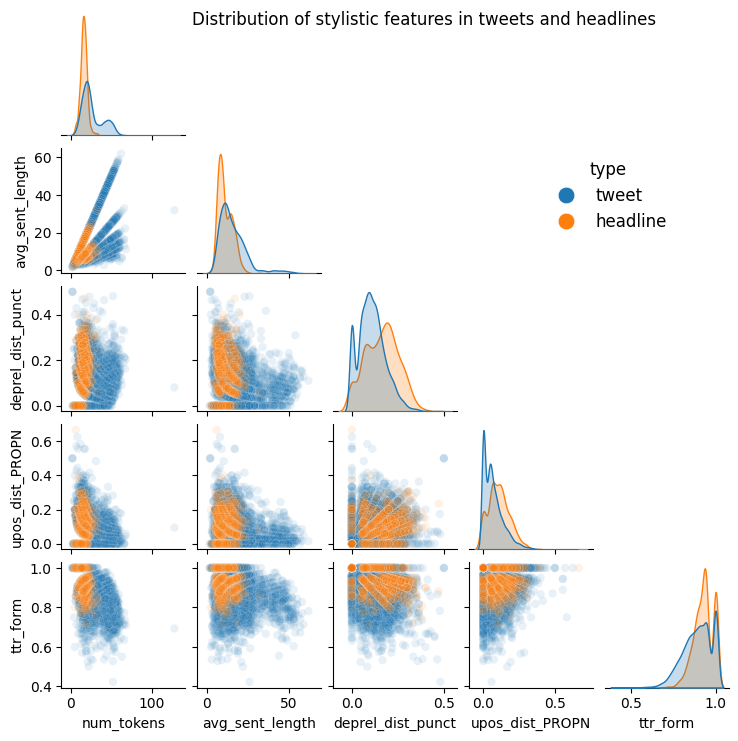

In [43]:
cols = ['num_tokens', 'avg_sent_length', 'deprel_dist_punct','upos_dist_PROPN', 'ttr_form','type']

g = sns.pairplot(df[cols],
             hue='type',
             corner=True,
             plot_kws={'alpha': .1},
             diag_kws={'common_norm': False},
             height=1.5)

sns.move_legend(g, loc='upper right', bbox_to_anchor=(.8, .8),
                fontsize="large", title_fontsize="large",
                markerscale=2)
g.legend.properties
for h in g.legend.legend_handles:
    h.set_alpha(1)
g.figure.suptitle("Distribution of stylistic features in tweets and headlines")
plt.show()